# VISUALIZE experiments results

In this visualization notebook, we will see how all the models behave, and how the different parameters affect model performance for te different available models, which are:

* Linear models
* KNN regression models
* MDA + RBF models

All models have similar and different behaviours. As an example, maybe all behave bad in certain locations, but some models might behave better with local predictors, while others might obtain better results when adding a regional + gradient predictor.

In [1]:
# basics
import os, sys

# arrays
import numpy as np
import xarray as xr

# application
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import panel as pn

pn.extension()

# to autocomplete code
%config Completer.use_jedi = False

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

from sscode.config import default_region_reduced
from sscode.plotting.config import _figsize, _fontsize_title
from sscode.plotting.utils import plot_ccrs_nz
from sscode.data import load_moana_hindcast

# from bokeh.plotting import figure, show, output_notebook
# output_notebook()

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


In [2]:
linear_stats = xr.open_dataset('../data/statistics/experiments/experiment_linear_final_20211029.nc')
linear_stats['ext_rmse'] = linear_stats['ext_rmse_9'].copy()
knn_stats = xr.open_dataset('../data/statistics/experiments/experiment_knn_final_20211011.nc')
xgb_stats = xr.open_dataset('../data/statistics/experiments/experiment_xgboost_final_20211013.nc')
max_final_metric = 0.0
min_final_metric = 1.0

for stats_ in [linear_stats,knn_stats,xgb_stats]:
    stats_['final_metric'] = ((
        (1-stats_.rel_rmse*2) + stats_.pearson*2 + (stats_.pocid/100) + (1-stats_.si) + \
        (stats_.rmse/stats_.ext_rmse)
    ) / 6) # final metric values
    # stats_plot['final_metric'] = (stats_plot['final_metric']-stats_plot['final_metric'].min())/\
    #     (stats_plot['final_metric'].max()-stats_plot['final_metric'].min())
    stats_['tu_test_bin'] = stats_.tu_test.where(stats_.tu_test<0.55,np.nan)
    max_final_metric = max(max_final_metric,stats_.final_metric.max())
    min_final_metric = min(min_final_metric,stats_.final_metric.min())
for stats_ in [linear_stats,knn_stats,xgb_stats]:
    stats_['final_metric'] = (stats_['final_metric']-min_final_metric)/(max_final_metric-min_final_metric)
                            
knn_stats_red = knn_stats.max(dim='k_neighbors')
xgb_stats_red = xgb_stats.max(dim=['max_depth','min_samples_split'])

In [3]:
linear_stats

<xarray.Dataset>
Dimensions:           (grad: 2, perpcs: 1, region: 3, site: 29, tlapse: 3, tresample: 3, tsize: 1, winds: 2)
Coordinates:
  * site              (site) int64 116 200 224 328 378 ... 1260 1296 1327 1442
Dimensions without coordinates: grad, perpcs, region, tlapse, tresample, tsize, winds
Data variables: (12/48)
    bias              (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    si                (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rmse              (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rel_rmse          (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_rmse_9        (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_rmse_95       (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ...                ...
    ext_kgeprime_95   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_99   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_999  (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_rmse          (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    final_metric      (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    tu_test_bin       (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...

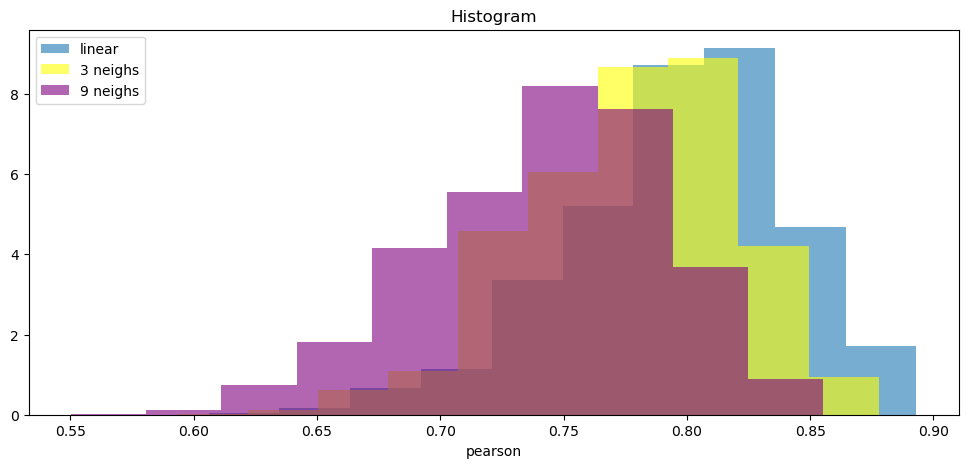

In [4]:
plt.figure(figsize=(12,5))
linear_stats.pearson.plot(alpha=0.6,label='linear',density=True)
knn_stats.isel(k_neighbors=0).pearson.plot(alpha=0.6,label='3 neighs',density=True,color='yellow')
# knn_stats.isel(kneighs=1).pearson.plot(alpha=0.6,label='6 neighs',density=True)
knn_stats.isel(k_neighbors=2).pearson.plot(alpha=0.6,label='9 neighs',density=True,color='purple')
plt.legend(loc='upper left')
plt.show()

Below, the parameters used when creating the loaded `linear_stats` and `knn_stats` are shown, so the future plots that will appear in the notebook can be understood. In this case, we decided to set the winds variable to False, as it do not provide much information, and it adds computation and coding issues when working with data in different locations at the same time. For the `sites` that will be analyzed, we just choosed the closest Moana v3 Hindcast nodes to the available tidal gauges, in case more detailed analysis is done.

```python 
    """
        Parameters used in experiments.ipynb when the loaded files were created
    """
    
    sites_to_analyze = np.unique(
        [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
          1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
          1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
        ]
    )
    pca_attrs_exp = {
        'calculate_gradient': [False,True], 
        'winds': [False,True],
        'time_lapse': [1,2,3], # 1 equals to NO time delay 
        'time_resample': ['6H','12H','1D'],
        'region': [('local',(1.5,1.5)),('local',(2.5,2.5)),(True,default_region_reduced)]
    }
    linear_attrs_exp = {
        'train_size': [0.7], 'percentage_PCs': [0.98]
    }
    knn_attrs_exp = {
        'train_size': [0.7], 'percentage_PCs': [0.98],
        'k_neighbors': [None,3,6,9] # None calculates the optimum k-neighs
    }
    xgboost_attrs_exp = {
        'train_size': [0.7], 'percentage_PCs': [0.98],
        'n_estimators': [50], 'max_depth': [10,12],
        'min_samples_split': [0.04,0.06],
        'learning_rate': [0.1], 'loss': ['ls'] # more could be added
    }
```

```{tip}
The effect of each available parameter in the different models performance will be commented in the cells below!!
```

In the following cell, we just create, based on the pca + model parameters, all the `x-labels` for the plots, and create the `stats_plot` parameter!!

In [5]:
stats_plot = linear_stats # EDIT TO PLOT KNN / XGBOOST

# generate labels for x-axis
variables_dictionary = {
    'calculate_gradient': ['GrF','GrT'],
    'winds': ['WF','WT'],
    'time_lapse': ['TL1','TL2','TL3'],
    'time_resample': ['6H','12H','1D'],
    'region': ['local1','local2','NZ'],
    'train_size': ['70%'],
    'percentage_pcs': ['98%'],
    'k_neighbors': ['best','3','6','9'],
    'max_depth': ['10','12'],
    'min_samples_split': ['4%','6%']
}

x_labels = []

for cg in variables_dictionary['calculate_gradient']:
    for ws in variables_dictionary['winds']:
        for tl in variables_dictionary['time_lapse']:
            for tr in variables_dictionary['time_resample']:
                for r in variables_dictionary['region']:
                    # for kn in variables_dictionary['k_neighbors']:
                    # for md in variables_dictionary['max_depth']:
                    # for mss in variables_dictionary['min_samples_split']:
                    x_labels.append(
                        cg+' - '+ws+' - '+tl+' - '+tr+' - '+r
                    )

## Plot selected locations

In the following cell, all the locations for the selected sites are plotted, please un comment the line with the magic command `%matplotlib` to zoom in the desires zones and see the locations correctly.

Below, some pictures summarizing the content in the plot generated in the code cell below:

```{figure} ../media/images/nz-locs-colors.png
---
width: 700px
name: nz-locs-colors
---
These are all the selected sites by color, based on the shore they are located
```

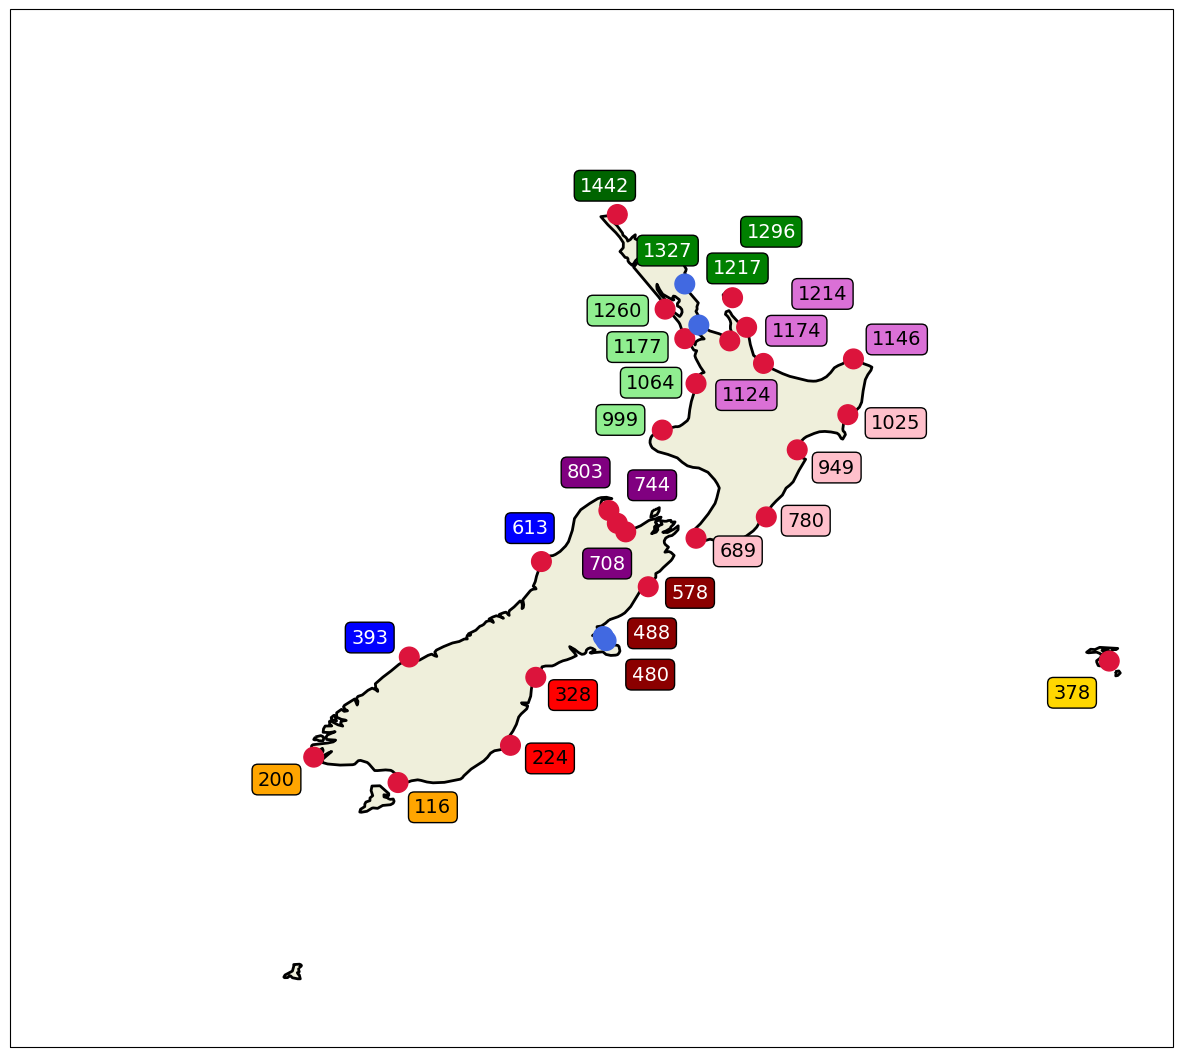

In [6]:
# and now we load the longitudes and latitudes for the selected sites
locations = load_moana_hindcast(plot=False)[['lon','lat']].sel(site=linear_stats.site.values)
# select colors for each location depending on the shore
locations_colors = [
    'orange','orange','red','red','gold','blue','darkred','darkred','darkred','blue','pink',
    'purple','purple','pink','purple','pink','lightgreen','pink','lightgreen','orchid','orchid','orchid',
    'lightgreen','orchid','green','lightgreen','green','green','darkgreen'
]
locations_colors_letters = [
    'black','black','black','black','black','white','white','white','white','white','black',
    'white','white','black','white','black','black','black','black','black','black','black',
    'black','black','white','black','white','white','white'
]
# [ 116,  200,  224,  328,  378,  393,  480,  488,  578,  613,  689,  708,
#   744,  780,  803,  949,  999, 1025, 1064, 1124, 1146, 1174, 1177, 1214,
#   1217, 1260, 1296, 1327, 1442
# ]
# plot all the locations with the colors
# %matplotlib to zoom in the map
fig, ax = plt.subplots(
    figsize=(15,15),subplot_kw={
        'projection':ccrs.PlateCarree(central_longitude=180)
    }
)
ax.set_facecolor('white')
#xr.plot.scatter(
#    locations,x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(),
#    zorder=200,s=100,marker='s',c=locations_colors_letters
#)
# xr.plot.scatter(
#     locations,x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(),
#     zorder=250,s=300,marker='*',c=locations_colors
# )
ax.scatter(
    x = locations.lon.values, y = locations.lat.values,
    c = np.where(np.mean(np.argmax(
        np.concatenate([
            linear_stats.final_metric.values.reshape(len(linear_stats.site.values),-1,1),
            knn_stats_red.final_metric.values.reshape(len(knn_stats_red.site.values),-1,1),
            xgb_stats_red.final_metric.values.reshape(len(xgb_stats_red.site.values),-1,1)
        ], axis=2), axis=2
    ),axis=1)<1,0,1),
    transform = ccrs.PlateCarree(), zorder=20, s=200, cmap=ListedColormap(['crimson','royalblue'])
)
delta_lons = [ 0.35,  # 116
              -1.2,   # 200
               0.45,  # 224
               0.4,   # 328
              -1.2,   # 378
              -1.25,  # 393
               0.55,  # 480
               0.65,  # 488
               0.5,   # 578
              -0.65,  # 613 
               0.5,   # 689
              -0.8,   # 708
               0.35,  # 744
               0.45,  # 780
              -0.9,   # 803
               0.45,  # 949
              -1.3,   # 999
               0.5,   # 1025
              -1.5,   # 1064
              -0.9,   # 1124
               0.4,   # 1146
               0.9,   # 1174
              -1.55,  # 1177
               1.1,   # 1214
               0.3,   # 1217
              -1.55,  # 1260
               0.3,   # 1296
              -0.9,   # 1327
              -0.8    # 1442
]
delta_lats = [-0.65,  # 116
              -0.6,   # 200
              -0.4,   # 224
              -0.5,   # 328
              -0.8,   # 378
               0.3,   # 393
              -0.85,  # 480
              -0.05,  # 488
              -0.25,  # 578
               0.6,   # 613 
              -0.4,   # 689
              -0.8,   # 708
               0.7,   # 744
              -0.2,   # 780
               0.7,   # 803
              -0.5,   # 949
               0.1,   # 999
              -0.3,   # 1025
              -0.1,   # 1064
              -0.8,   # 1124
               0.3,   # 1146
               0.1,   # 1174
              -0.3,   # 1177
               0.6,   # 1214
               1.1,   # 1217
              -0.15,  # 1260
               1.3,   # 1296
               0.6,   # 1327
               0.5    # 1442
]
for isite,color in zip(range(len(locations.site)),locations_colors):
    ax.text(
        x=locations.lon.values[isite]+delta_lons[isite],
        y=locations.lat.values[isite]+delta_lats[isite],
        s=locations.site.values.astype(str)[isite],
        transform=ccrs.PlateCarree(),size=14,zorder=40,
        backgroundcolor=color,color=locations_colors_letters[isite],
        bbox=dict(facecolor=color,edgecolor='black',boxstyle='round')
    )
plot_ccrs_nz([ax],plot_labels=(False,5,5))

In [7]:
locations

<xarray.Dataset>
Dimensions:  (site: 29)
Coordinates:
  * site     (site) int64 116 200 224 328 378 393 ... 1217 1260 1296 1327 1442
Data variables:
    lon      (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lat      (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>

## MDA + RBF models

Now, we load the results using the "best" predictor regarding the linear model metrics, and interpolating the storm surge using a certain number of SLP pcs and MDA cases!!

In [8]:
mdarbf_stats = xr.open_dataset(
    '../data/statistics/experiments/experiment_mdarbf_shores_1D_local_winds_grad_25_10_1500.nc')
mdarbf_stats['final_metric'] = ((
    (1-mdarbf_stats.rel_rmse*2) + mdarbf_stats.pearson*2 + (mdarbf_stats.pocid/100) + (1-mdarbf_stats.si) + \
    (mdarbf_stats.rmse/mdarbf_stats.ext_rmse)
) / 6) # final metric values
mdarbf_stats['tu_test_bin'] = mdarbf_stats.tu_test.where(mdarbf_stats.tu_test<0.55,np.nan)
# max_final_metric = max(max_final_metric,stats_.final_metric.max())
# min_final_metric = min(min_final_metric,stats_.final_metric.min())
mdarbf_stats['final_metric'] = (mdarbf_stats['final_metric']-min_final_metric)/(max_final_metric-min_final_metric)

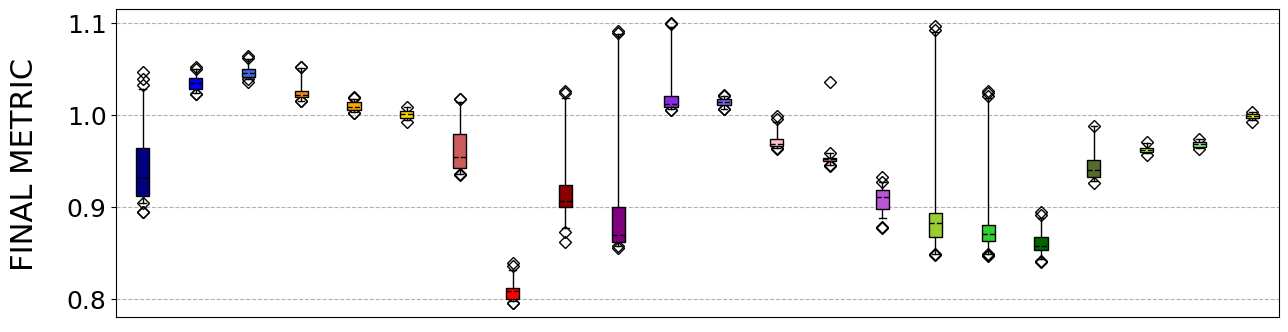

In [9]:
# import plotting
from sscode.plotting.utils import get_n_colors
import matplotlib
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
# make the boxplots
fig, ax = plt.subplots(figsize=(15,4))
box = ax.boxplot(
    [mdarbf_stats.sel(shore=i).final_metric.max(dim='experiment').values \
     for i in range(len(np.unique(mdarbf_stats.shore.values)))],
    patch_artist=True, sym='D', vert=True, whis=[2,98], widths=0.25, 
    medianprops={'c':'k','lw':1,'ls':'--'}
)
loc_colors = [
    'navy','blue','royalblue','darkorange','orange','gold','indianred','red','darkred',
    'purple','blueviolet','mediumslateblue','pink','palevioletred','mediumorchid',
    'yellowgreen','limegreen','darkgreen','darkolivegreen','greenyellow','lightgreen','yellow'
]
for patch, color in zip(box['boxes'], loc_colors):
    patch.set_facecolor(color)
ax.set_xticks([])
ax.set_ylabel('FINAL METRIC',fontsize=22,labelpad=20)
ax.grid(ls='--')
plt.show()

## Plot all metrics

...

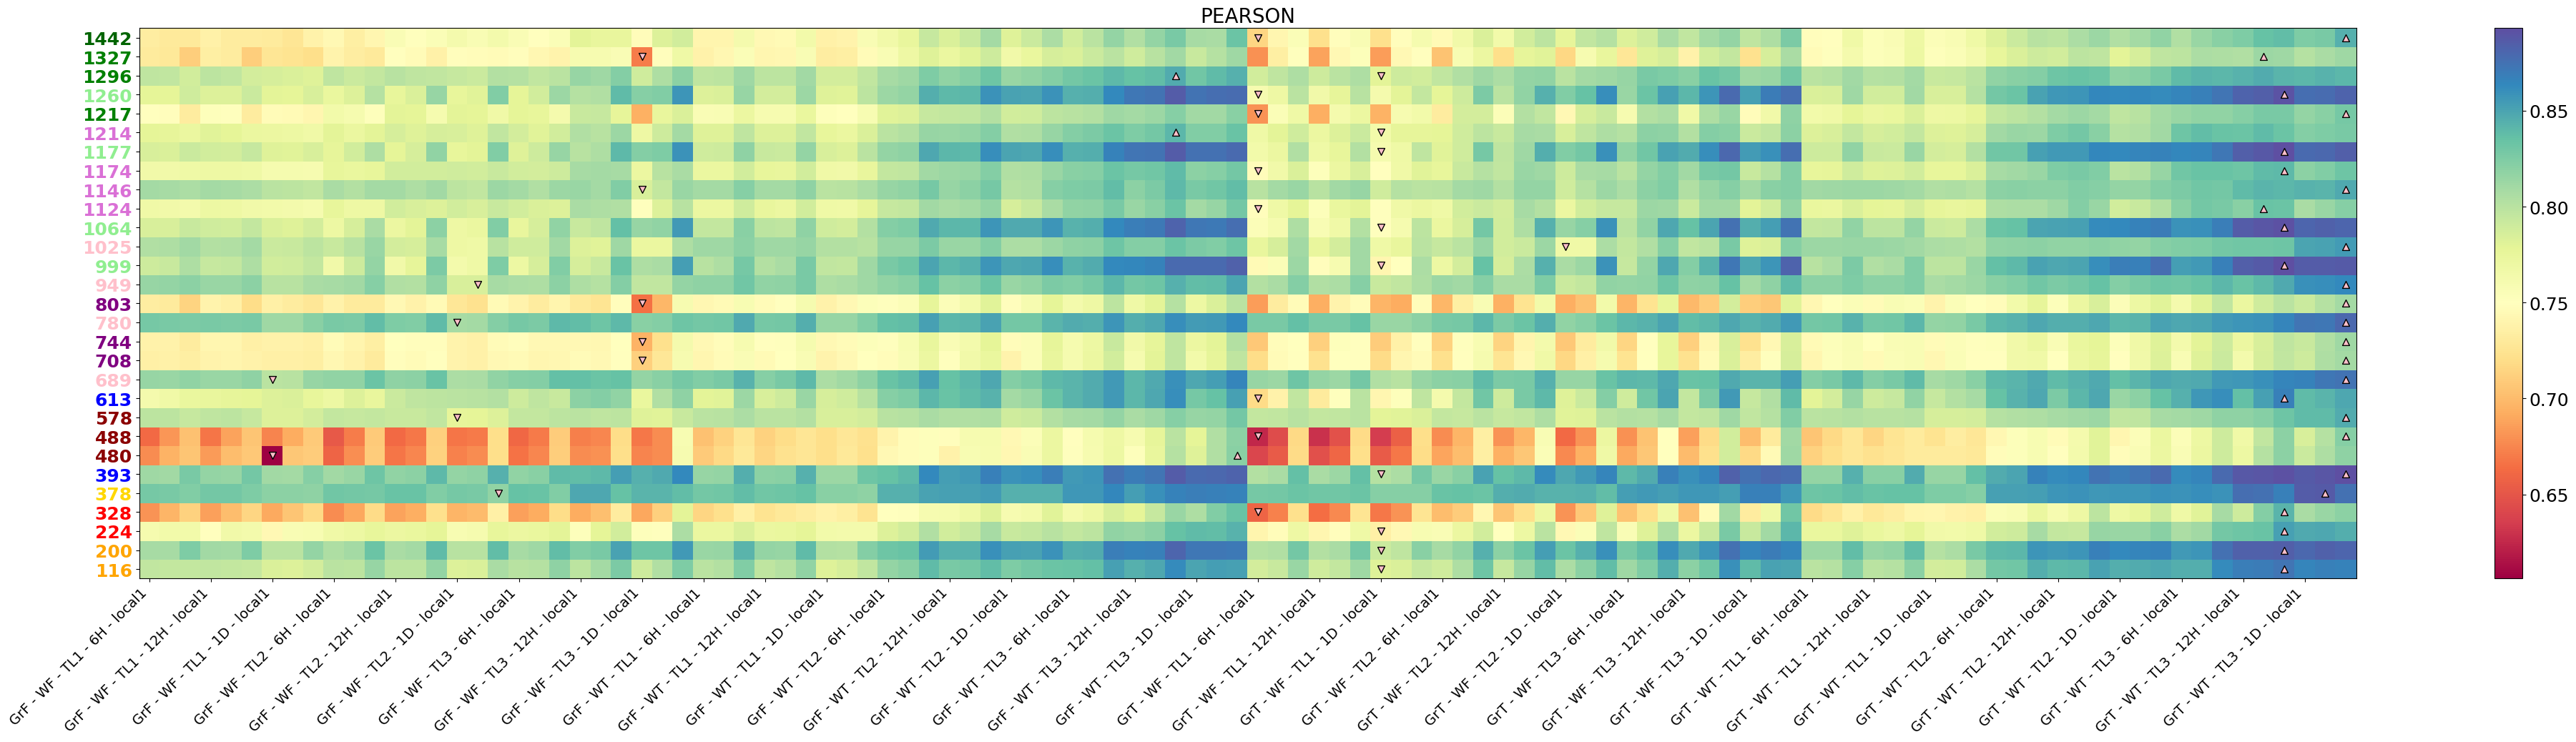

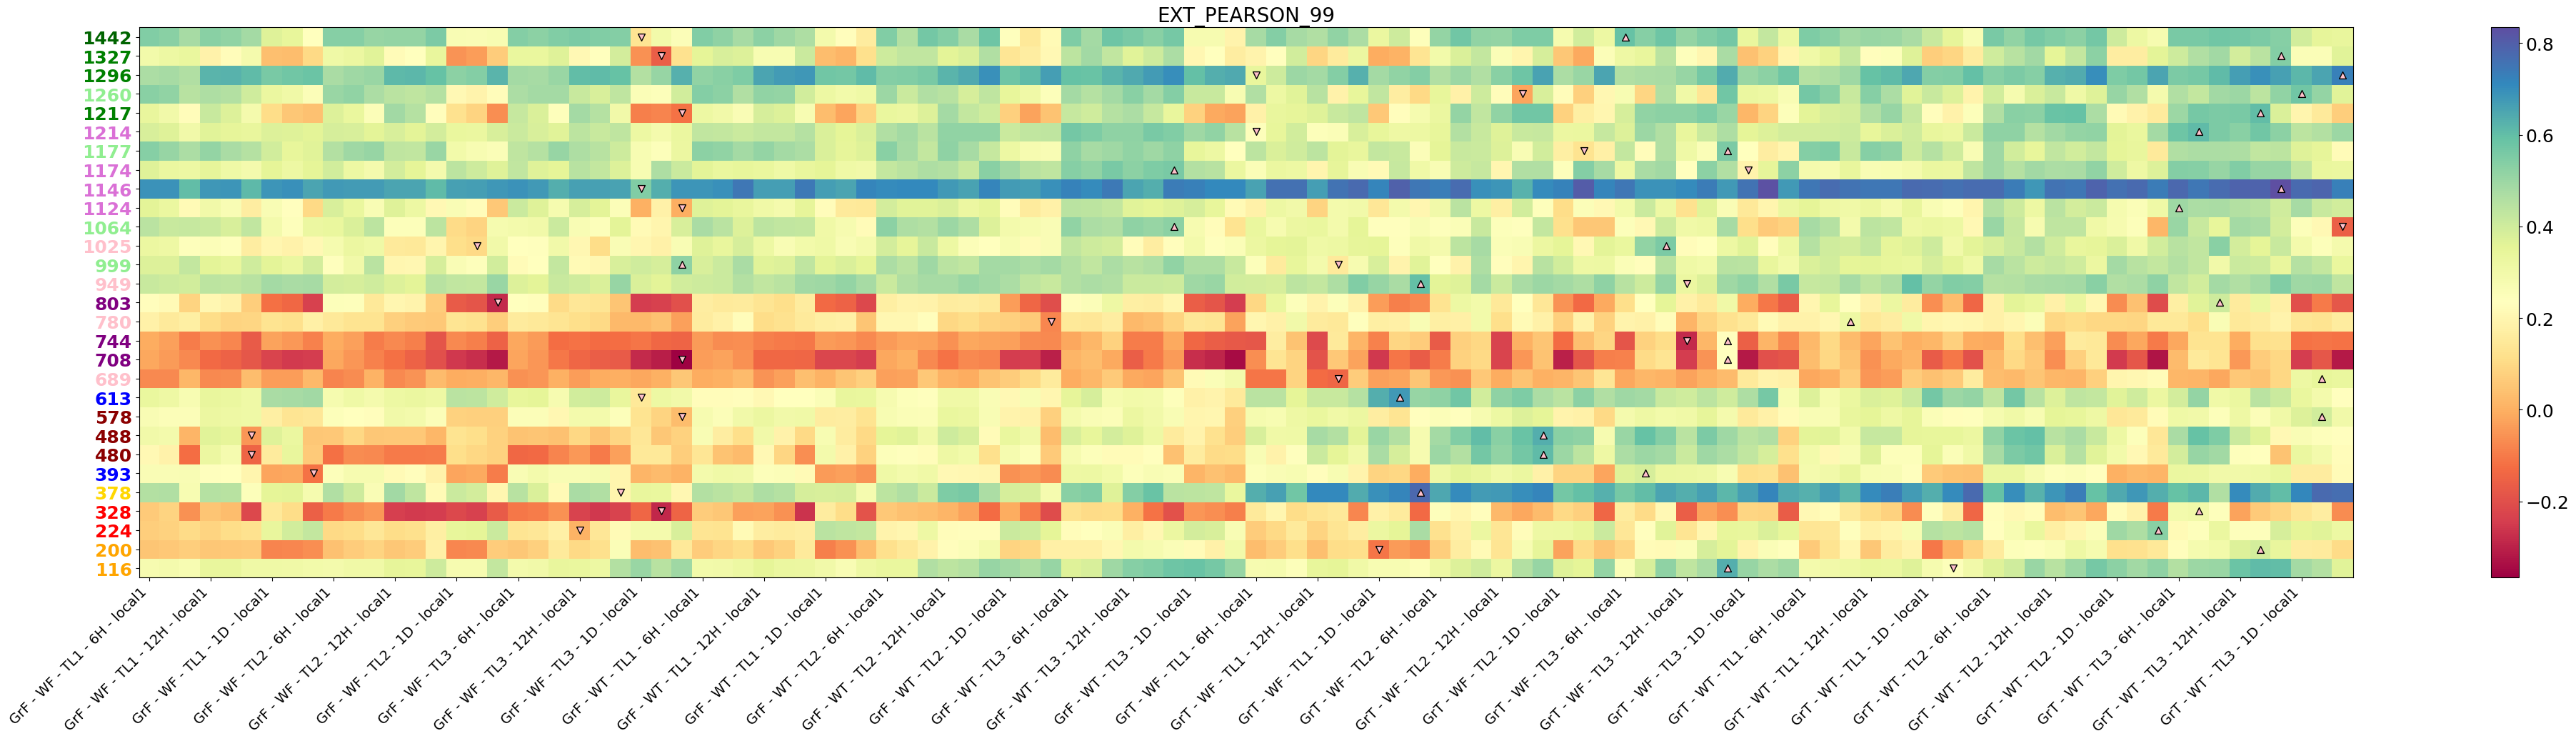

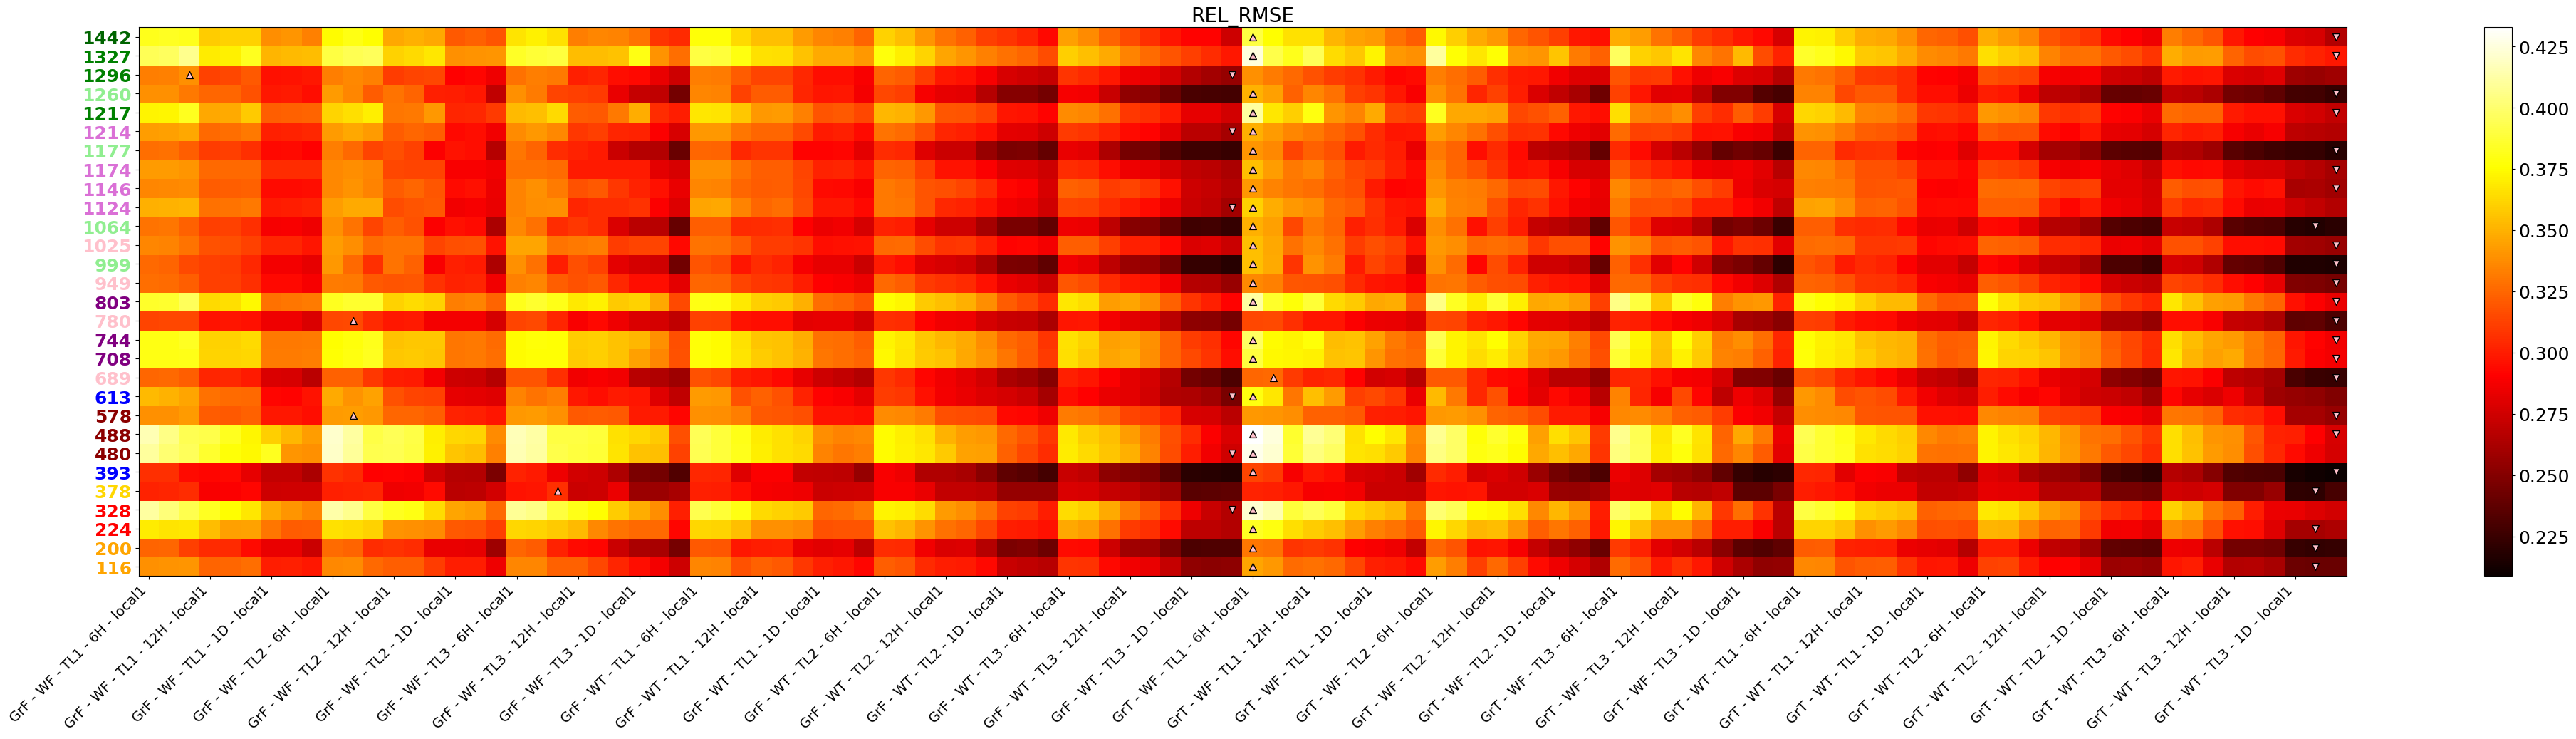

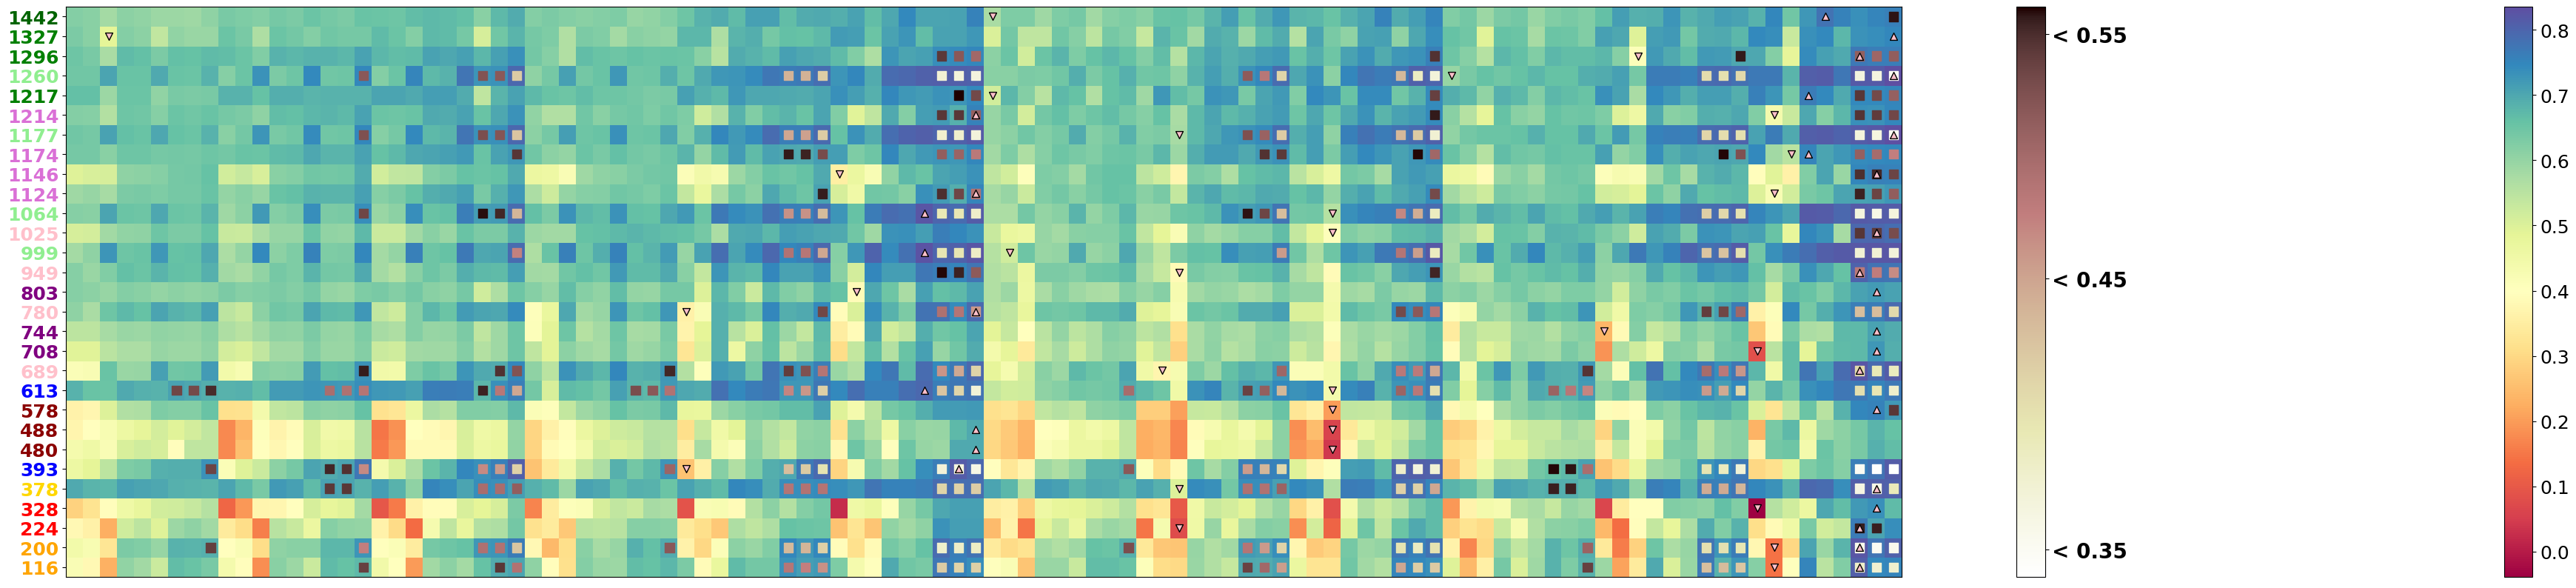

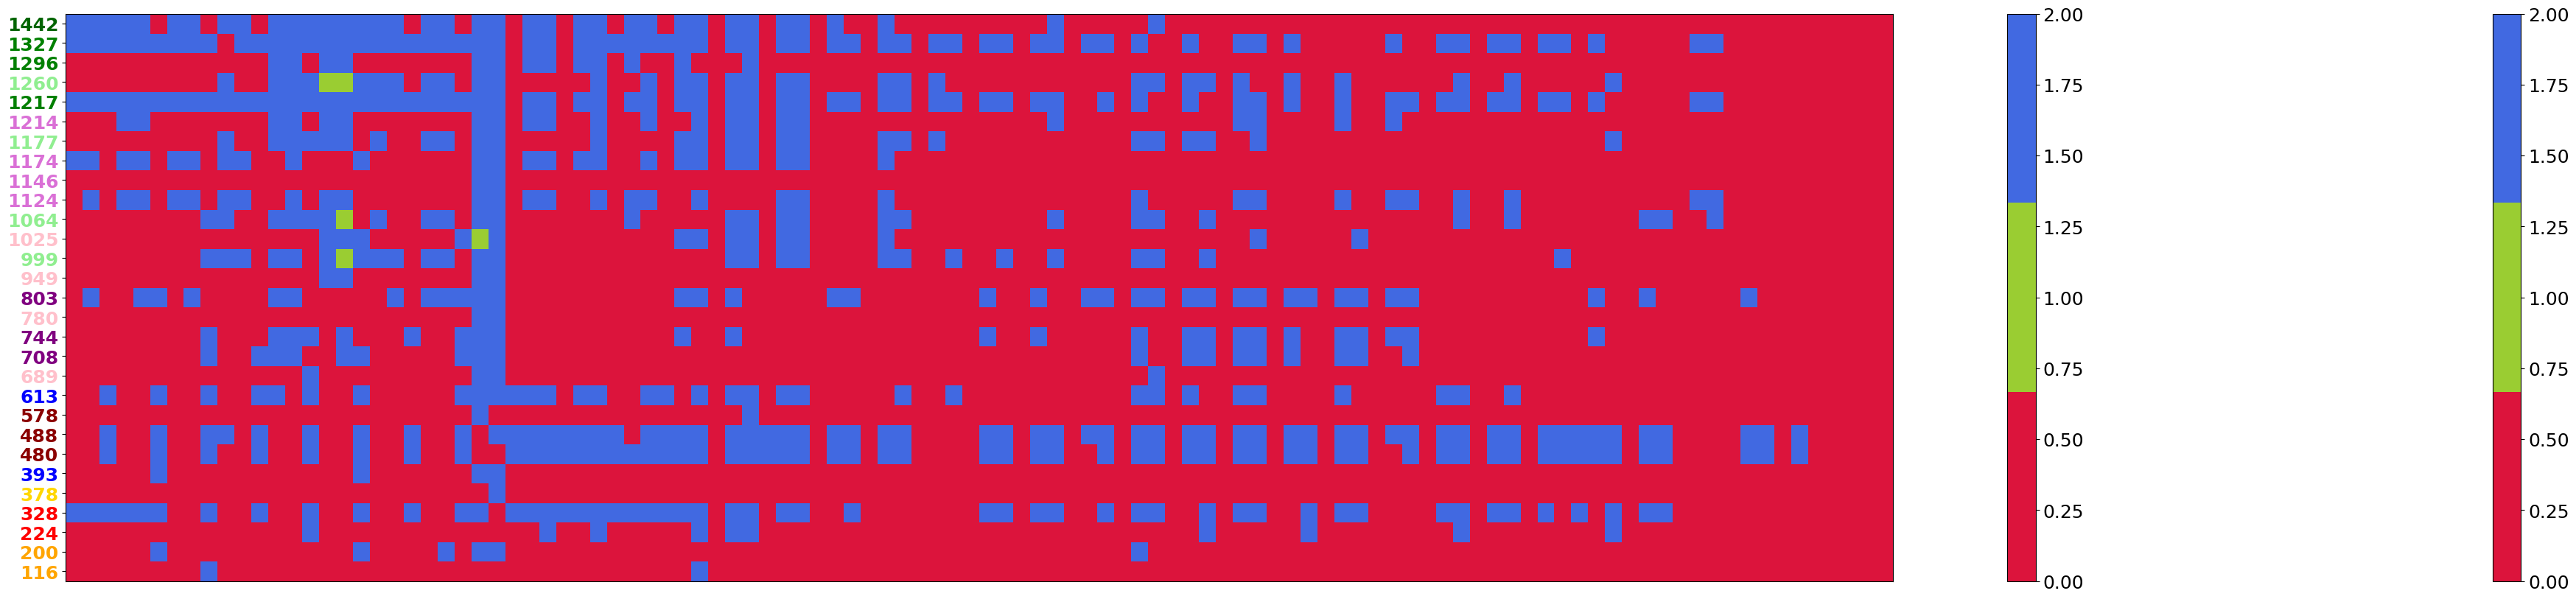

In [11]:
metrics_cmaps = { # ascendig = True
    'expl_var': 'Spectral', 'me': 'plasma_r', 'mae': 'hot', 'mse': 'hot', 'ext_rmse': 'plasma_r',
    'medae': 'hot', 'tweedie': 'jet', 'bias': 'pink_r', 'si': 'Spectral_r',
    'rmse': 'plasma_r', 'pearson': 'Spectral', 'spearman': 'jet', 'rscore': 'Spectral',
    'ext_pearson': 'Spectral', 'rel_rmse': 'hot', 'ext_rel_rmse': 'hot',
    'tu_test': 'jet', 'pocid': 'jet', 'final_metric': 'Spectral',
    'ext_pearson_99':'Spectral','ext_kgeprime_99':'Spectral','kgeprime':'Spectral'
}

# extract best sites order
num_sites = len(stats_plot.site)
sites_order = np.argsort(
    np.mean(stats_plot['pearson'].values.reshape(num_sites,-1),axis=1)
) # this is not used
    
for metric_to_plot in ['pearson','ext_pearson_99','rel_rmse','kgeprime']:
    fig, ax = plt.subplots(figsize=(50,10))
    # extract metric values from xarray.Dataset
    metric_values = stats_plot[metric_to_plot].values.reshape(num_sites,-1)[:,:] \
        if metric_to_plot!='bias' else np.abs(
            stats_plot[metric_to_plot].values.reshape(num_sites,-1)[:,:]
        )
    # plot pcolors 
    pc = ax.pcolor(
        metric_values, cmap=metrics_cmaps[metric_to_plot],
        vmin=np.nanmin(metric_values),vmax=np.nanmax(metric_values)
    )
    ax.scatter(
        np.argsort(metric_values)[:,0].reshape(-1) + 0.5, # last values in array
        np.repeat(np.arange(num_sites),1) + 0.5, # y_positons
        marker='v',facecolors='pink',edgecolors='black',linewidth=1,s=50,
        zorder=10
    )
    ax.scatter(
        np.argsort(metric_values)[:,-1].reshape(-1) + 0.5, # last values in array
        np.repeat(np.arange(num_sites),1) + 0.5, # y_positons
        marker='^',facecolors='pink',edgecolors='black',linewidth=1,s=50,
        zorder=10
    )
    tutc = ax.scatter(
        np.repeat(
            np.arange(metric_values.shape[1]).reshape(1,-1),
            metric_values.shape[0],axis=0
        ).reshape(-1) + 0.5,
        np.repeat(
            np.arange(metric_values.shape[0]),
            metric_values.shape[1]
        ).reshape(-1) + 0.5,
        c = stats_plot.tu_test_bin.values.reshape(metric_values.shape[0],-1).reshape(-1),
        marker='s', s=80, zorder=8, cmap='pink_r', vmax=0.55, vmin=0.34
    ) if metric_to_plot=='kgeprime' else None
    # plot vertical lines to help eye
    # ax.axvline(x=62.5,linewidth=2,linestyle='--',c='grey')
    # ax.axvline(x=71.5,linewidth=2,linestyle='--',c='grey')
    cbar = fig.colorbar(pc,ax=ax)
    jeje = fig.colorbar(tutc,ax=ax) if metric_to_plot=='kgeprime' else None
    jeje.set_ticks([0.35,0.45,0.54]) if metric_to_plot=='kgeprime' else None
    ticklabs = jeje.ax.get_yticklabels() if metric_to_plot=='kgeprime' else None
    jeje.ax.set_yticklabels(['< 0.35','< 0.45','< 0.55'], fontsize=20,
                           fontweight='bold') if metric_to_plot=='kgeprime' else None
    #cbar.ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0]) if metric_to_plot=='kgeprime' else None
    #cbar.ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=20,
    #                       fontweight='bold') if metric_to_plot=='kgeprime' else None
    ax.set_yticks(np.arange(num_sites)+0.5) # these are the positions, and below the labels = sites
    ax.set_yticklabels(stats_plot.site.values[:],fontweight='bold',fontsize=18)
    for ytick,color in zip(ax.get_yticklabels(),locations_colors):
        ytick.set_color(color)
    ax.set_xticks(np.arange(0,metric_values.shape[1],3)+0.5)
    ax.set_xticklabels(x_labels[::3],fontsize=14)
    plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
    ax.set_xticks([]) if metric_to_plot=='kgeprime' else None
    ax.set_title(metric_to_plot.upper(),fontsize=20) if metric_to_plot!='kgeprime' else None
    plt.show()
from sscode.plotting.utils import get_n_colors
fig, ax = plt.subplots(figsize=(50,10))
best = ax.pcolor(np.argmax(
    np.concatenate([
        linear_stats.final_metric.values.reshape(len(linear_stats.site.values),-1,1),
        knn_stats_red.final_metric.values.reshape(len(knn_stats_red.site.values),-1,1),
        xgb_stats_red.final_metric.values.reshape(len(xgb_stats_red.site.values),-1,1)
    ], axis=2), axis=2
), cmap=ListedColormap(['crimson','yellowgreen','royalblue']))
ax.set_yticks(np.arange(num_sites)+0.5) # these are the positions, and below the labels = sites
ax.set_yticklabels(stats_plot.site.values[:],fontweight='bold',fontsize=18)
for ytick,color in zip(ax.get_yticklabels(),locations_colors):
    ytick.set_color(color)
cbar = fig.colorbar(best)
fig.colorbar(best)
ax.set_xticks([])
plt.show()

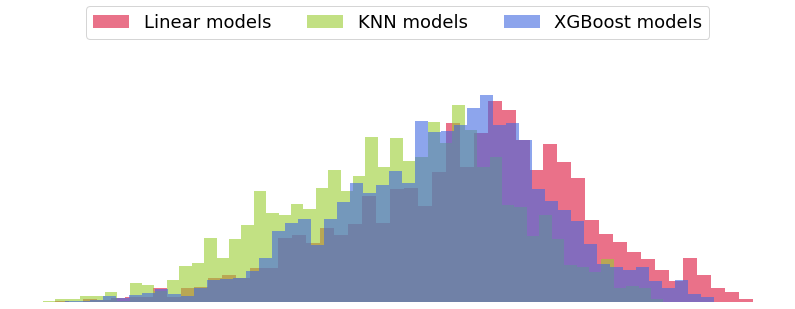

In [61]:
plt.figure(figsize=(14,4))
linear_stats.final_metric.plot(label='Linear models',alpha=0.6,bins=50,density=True,color='crimson')
knn_stats_red.final_metric.plot(label='KNN models',alpha=0.6,bins=50,density=True,color='yellowgreen')
xgb_stats_red.final_metric.plot(label='XGBoost models',alpha=0.6,bins=50,density=True,color='royalblue')
plt.legend(fontsize=18,ncol=3,loc='upper center',bbox_to_anchor=(0.5, 1.4))
plt.axis('off')
plt.title('')
plt.show()

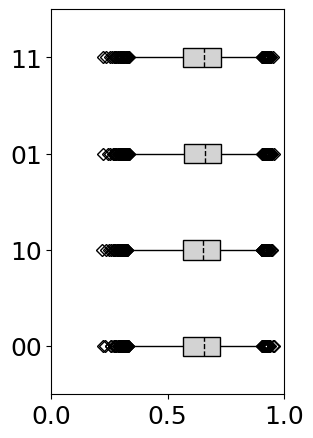

In [150]:
import matplotlib
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
fig, ax = plt.subplots(figsize=(3,5))
box = ax.boxplot([xgb_stats.isel(max_depth=0,min_samples_split=0).final_metric.values.reshape(-1),
             xgb_stats.isel(max_depth=1,min_samples_split=0).final_metric.values.reshape(-1),
             xgb_stats.isel(max_depth=0,min_samples_split=1).final_metric.values.reshape(-1),
             xgb_stats.isel(max_depth=1,min_samples_split=1).final_metric.values.reshape(-1)],
           labels=['00','10','01','11'], patch_artist=True, sym='D', vert=False, whis=[1,99], widths=0.2, 
    medianprops={'c':'k','lw':1,'ls':'--'}, notch=False
           )
for patch, color in zip(box['boxes'], ['lightgrey']*4):
    patch.set_facecolor(color)
ax.set_xticks([0,0.5,1.0])
plt.show()

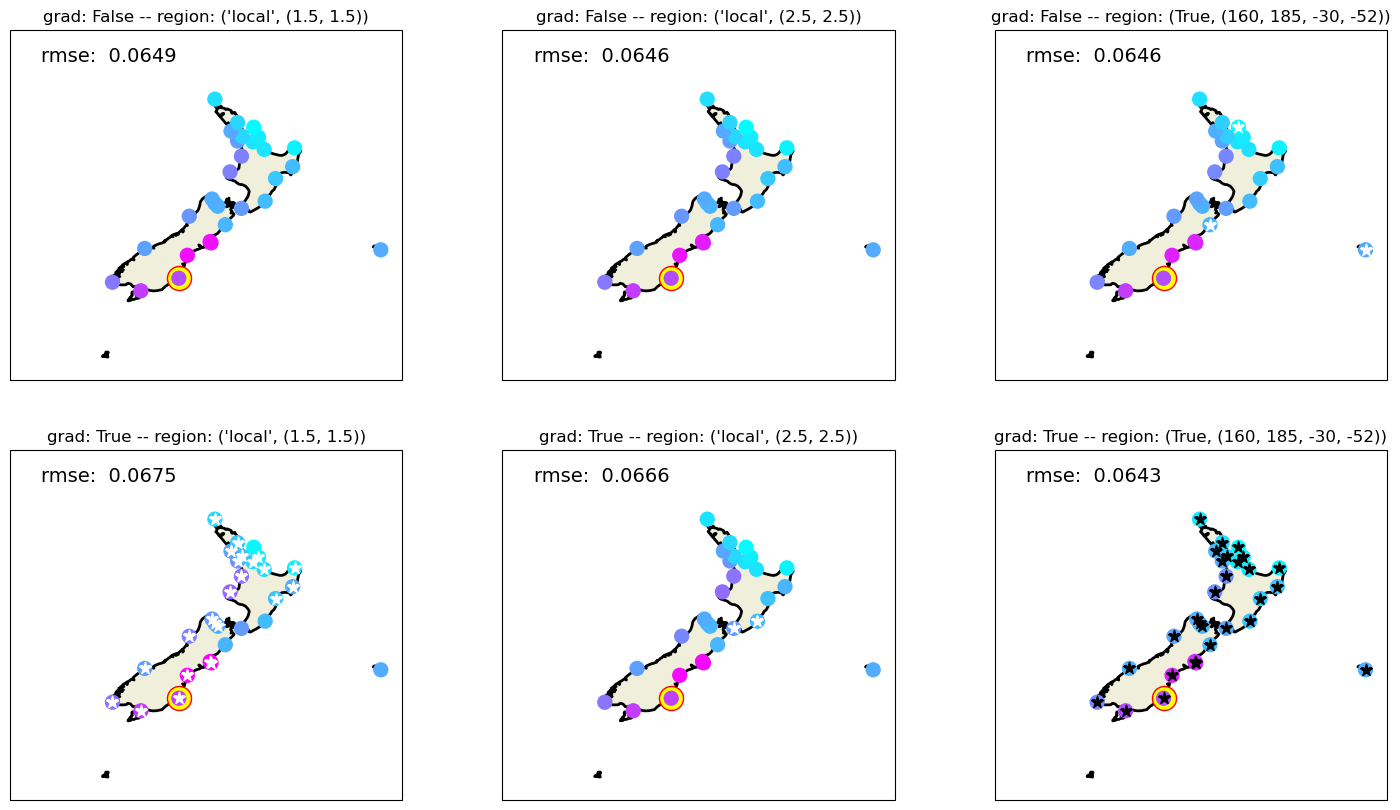

In [11]:
pca_attrs = {
    'grad': [False,True], 
    'winds': [False,True],
    'tlapse': [1,2,3], # 1 equals to NO time delay 
    'tresample': ['6H','12H','1D'],
    'region': [('local',(1.5,1.5)),('local',(2.5,2.5)),(True,default_region_reduced)]
}
linear_attrs = {
    'tsize': [0.7], 'perpcs': [0.98]
}
knn_attrs = {
    'tsize': [0.7], 'perpcs': [0.98],
    'kneighs': ['best',3,6,9] # None calculates the optimum k-neighs
}
limits_metrics = {
    'bias': [-0.2,0.2],
    'si': [0.5,1.5],
    'rmse': [0.0,0.1],
    'pearson': [0.7,1.0],
    'spearman': [0.7,1.0]
}


def plot_results(model='linear',metric='rmse',var_1='grad',var_2='region',isite=2,
                 extra_1=0,extra_2=0,extra_3=0,extra_4=0,extra_5=0,extra_6=0):
    
    # TODO: add docstring
    
    # print(pca_attrs, linear_attrs)
    
    stats = linear_stats if model=='linear' else knn_stats
    model_attrs = linear_attrs if model=='linear' else knn_attrs
    
    var_1_values = pca_attrs[var_1] if var_1 in pca_attrs.keys() \
        else model_attrs[var_1]
    var_2_values = pca_attrs[var_2] if var_2 in pca_attrs.keys() \
        else model_attrs[var_2]    
    
    nrows, ncols = len(var_1_values), len(var_2_values)
    
    fig, axes = plt.subplots(
        nrows=nrows,ncols=ncols,figsize=(ncols*6,nrows*5),
        subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}
    )
    
    metrics_no_plot = []
    metrics_no_plot_values = [
        extra_1,extra_2,extra_3,extra_4,extra_5,extra_6
    ]
    for dim in stats.dims: metrics_no_plot.append(dim) \
        if dim!=var_1 and dim!=var_2 and dim!= 'site' else None   
    # default variables can be changed here
        
    metric_stats = stats[metric].isel(
        dict(zip(metrics_no_plot,metrics_no_plot_values[:len(metrics_no_plot)]))
    )
    max_model = np.argmax(metric_stats.values.reshape(
        len(metric_stats.site.values),-1
    ), axis=1)
    min_model = np.argmin(metric_stats.values.reshape(
        len(metric_stats.site.values),-1
    ), axis=1)
    
    i_model = 0
        
    for irow in range(nrows):
        for icol, ax in enumerate(axes[irow,:]):
                        
            ps = ax.scatter(
                x=locations.lon.values, y=locations.lat.values,
                c=metric_stats.isel(
                    {var_1:irow,var_2:icol}
                ).values, cmap='cool', zorder=200, s=100,
                vmin=metric_stats.min(), vmax=metric_stats.max(),
                transform=ccrs.PlateCarree()
            ) # metric values
            ax.text(
                x=162, # locations.lon.values[isite],
                y=-32, # locations.lat.values[isite],
                s=metric + ':  ' + str(metric_stats.isel(
                    {var_1:irow,var_2:icol,'site':isite}
                ).values)[:6], transform=ccrs.PlateCarree(),
                size=14 # change size if wanted
            ) # metric value in a desired location
            ax.scatter(
                x=locations.lon.values[isite],
                y=locations.lat.values[isite],
                s=300, transform=ccrs.PlateCarree(),
                zorder=150, c='yellow',edgecolors='red'
            ) # highlight desired location
            
            # highlight best models in screen
            sites_to_mark_max = np.where(max_model==i_model)[0]
            sites_to_mark_min = np.where(min_model==i_model)[0]
            
            if len(sites_to_mark_max):
                ax.scatter(
                    x=locations.lon.values[sites_to_mark_max],
                    y=locations.lat.values[sites_to_mark_max],
                    marker='*', c='white', s=80, edgecolors='white',
                    transform=ccrs.PlateCarree(), zorder=300
                )
            if len(sites_to_mark_min):
                ax.scatter(
                    x=locations.lon.values[sites_to_mark_min],
                    y=locations.lat.values[sites_to_mark_min],
                    marker='*', c='black', s=80, edgecolors='black',
                    transform=ccrs.PlateCarree(), zorder=300
                )
                
            ax.set_title(
                '{}: {} -- {}: {}'.format(
                    var_1, var_1_values[irow], 
                    var_2, var_2_values[icol]
                )
            ) # plot the subplots title
            
            i_model += 1
            
    plot_ccrs_nz(axes.flatten(),plot_labels=(False,None,None))
    for ax in axes.flatten(): ax.set_facecolor('lightblue')
    suptitle = metric.upper() + '\n {} \n'.format(
        dict(zip(metrics_no_plot,metrics_no_plot_values[:len(metrics_no_plot)]))
    ) # add default variables to suptitle
    fig.suptitle(suptitle,fontsize=20)
    cbar_ax = fig.add_axes([0.93,0.15,0.03,0.7])
    cb = fig.colorbar(ps,cax=cbar_ax,orientation='vertical')   
    
    plt.close()
    
    return fig
    
    
kw = dict(
    model=['linear','knn'],
    metric=list(limits_metrics.keys()),
    var_1=list(pca_attrs.keys())+list(linear_attrs.keys())+['kneighs'],
    var_2=list(pca_attrs.keys())+list(linear_attrs.keys())+['kneighs'],
    isite=range(10), # this is to modify desired locations print
    extra_1=range(3),extra_2=range(3),extra_3=range(3),
    extra_4=range(3),extra_5=range(3),extra_6=range(3)
)
i = pn.interact(plot_results,**kw)

In [12]:
print(i)

Column
    [0] Column
        [0] Select(name='model', options=['linear', 'knn'], value='linear')
        [1] Select(name='metric', options=['bias', 'si', ...], value='rmse')
        [2] Select(name='var_1', options=['grad', 'winds', ...], value='grad')
        [3] Select(name='var_2', options=['grad', 'winds', ...], value='region')
        [4] DiscreteSlider(formatter='%d', name='isite', options=[0, 1, 2, 3, 4, ...], value=2)
        [5] DiscreteSlider(formatter='%d', name='extra_1', options=[0, 1, 2], value=0)
        [6] DiscreteSlider(formatter='%d', name='extra_2', options=[0, 1, 2], value=0)
        [7] DiscreteSlider(formatter='%d', name='extra_3', options=[0, 1, 2], value=0)
        [8] DiscreteSlider(formatter='%d', name='extra_4', options=[0, 1, 2], value=0)
        [9] DiscreteSlider(formatter='%d', name='extra_5', options=[0, 1, 2], value=0)
        [10] DiscreteSlider(formatter='%d', name='extra_6', options=[0, 1, 2], value=0)
    [1] Row
        [0] Matplotlib(Figure, nam

In [13]:
panel = pn.Column(
    pn.Row(
        pn.pane.Markdown('''
            ## Results of all the models are shown below
        ''')
    ),
    pn.Row(
        i[0][0],i[0][1],i[0][2],i[0][3],i[0][4]
    ),
    pn.Row(
        i[0][5],i[0][6],i[0][7],i[0][8],i[0][9]
    ),
    pn.Row(i[0][10], pn.pane.Markdown(
        ''' PCA attributes: {} and Models attributes: LINEAR: {} ---- KNN {} '''.format(
            pca_attrs, linear_attrs, knn_attrs
        )
    )),
    pn.Row(i[1][0])
)

## Panel results

Below, when running the cell, a server will be displayed with an interactive window to see results. This is the aspect of the window:

```{figure} ../media/images/results-visualizator.png
---
width: 700px
name: results-panel
---
This is the aspect of the interactive panel, created with [Panel](https://panel.holoviz.org/#)
```

Launching server at http://localhost:42177


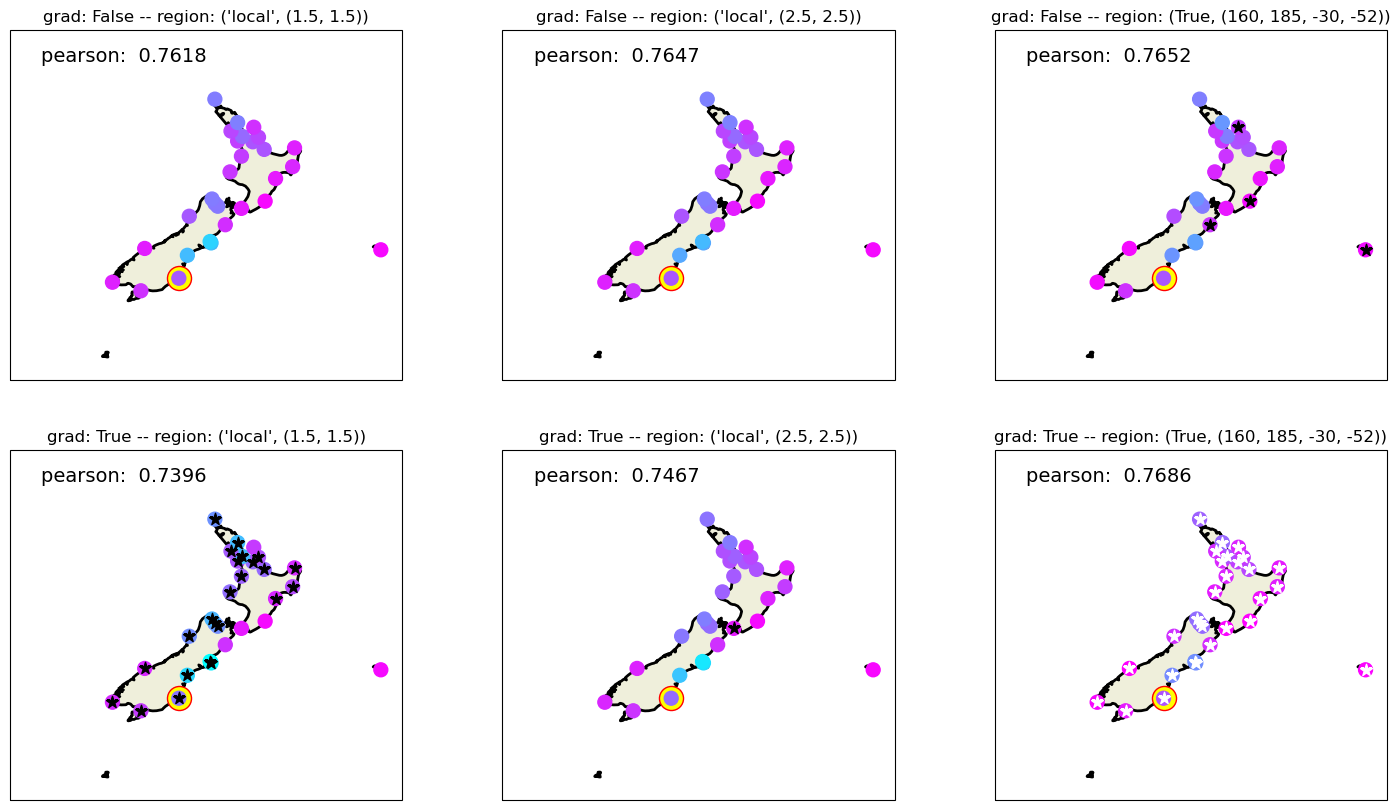

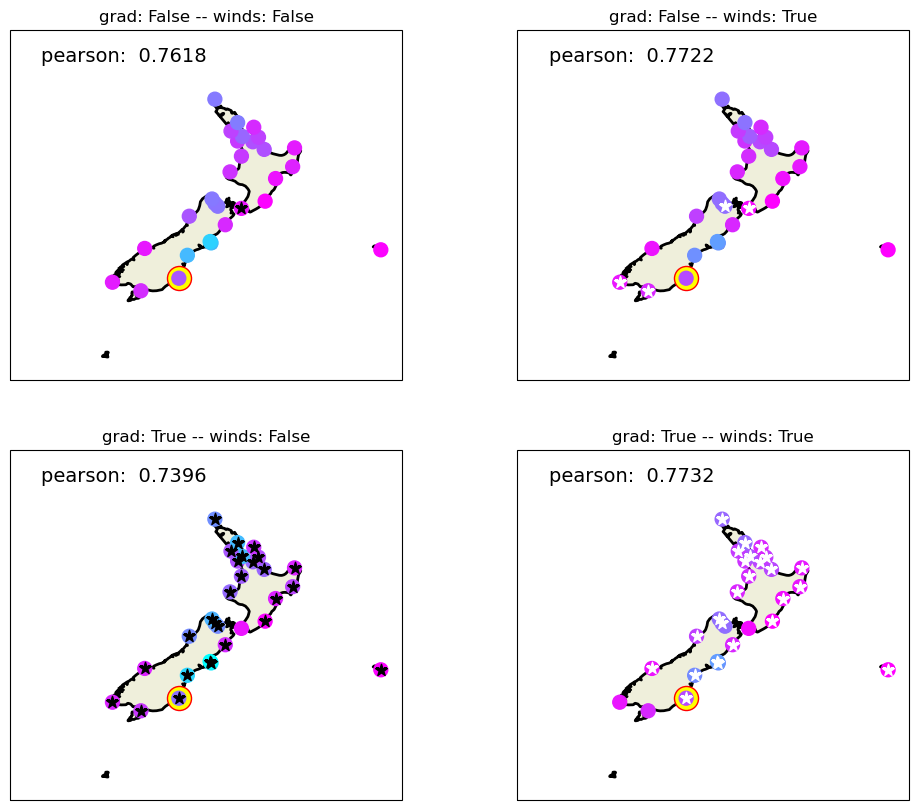

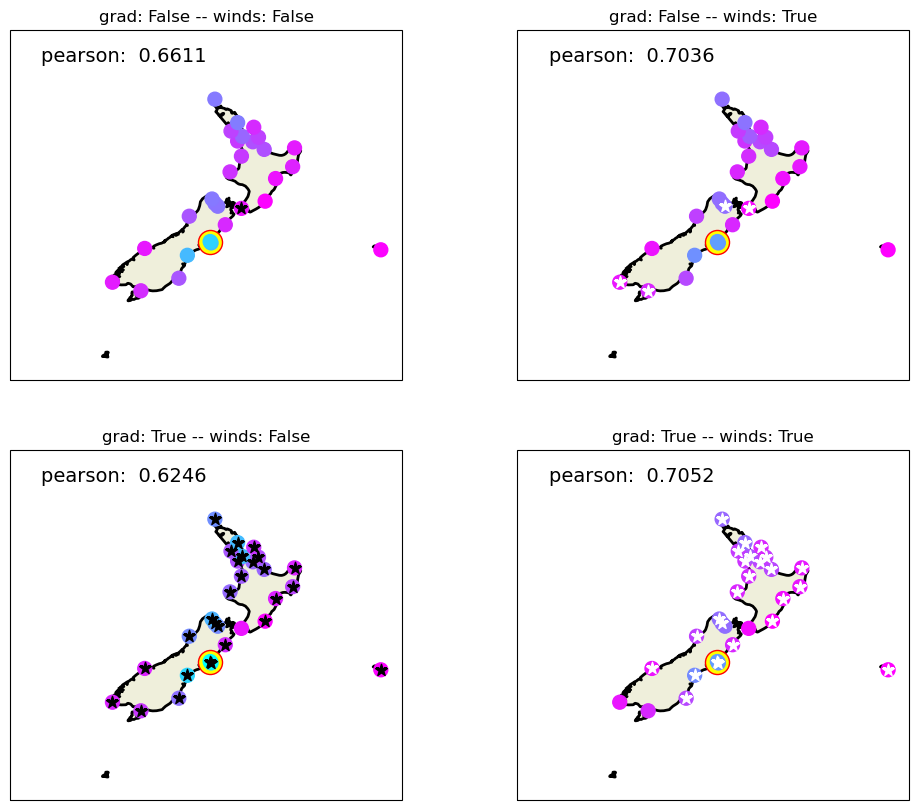

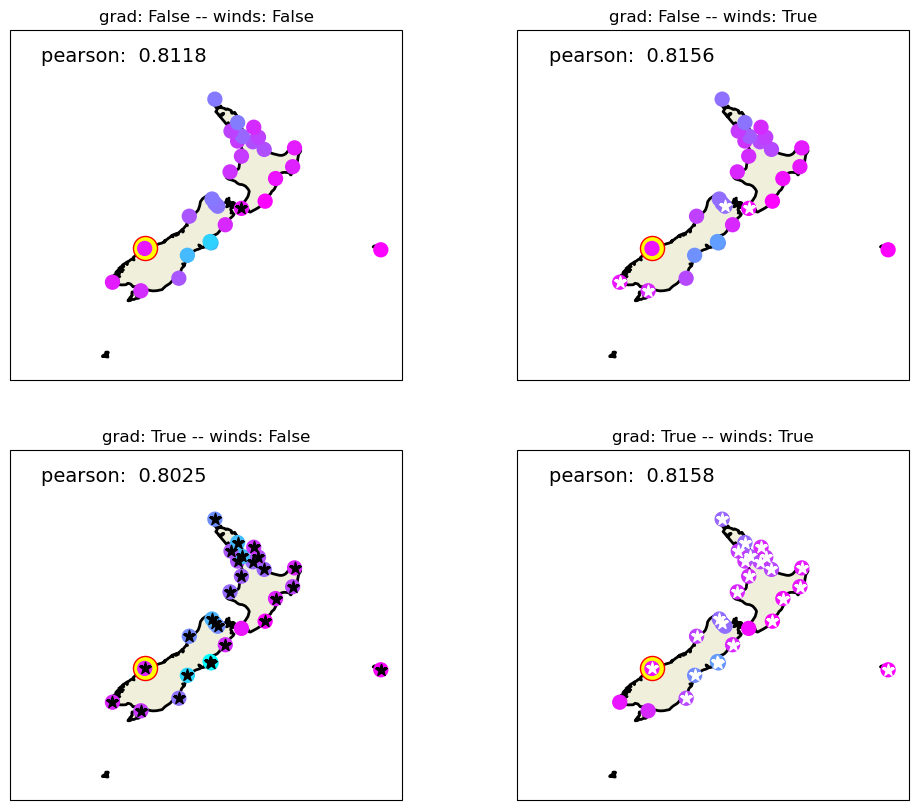

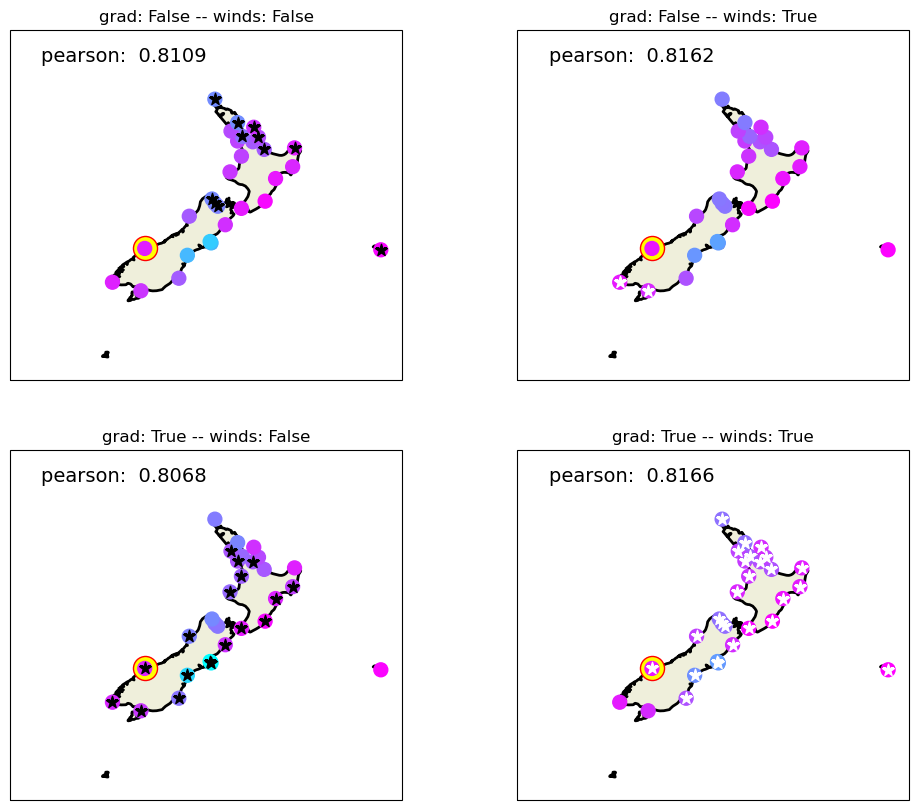

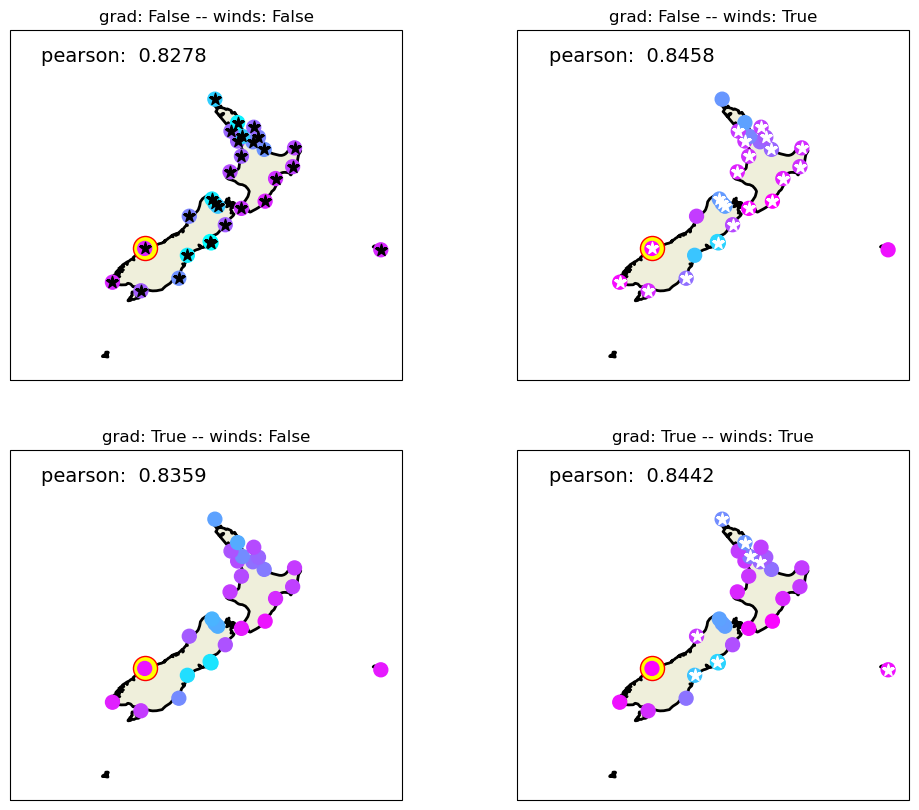

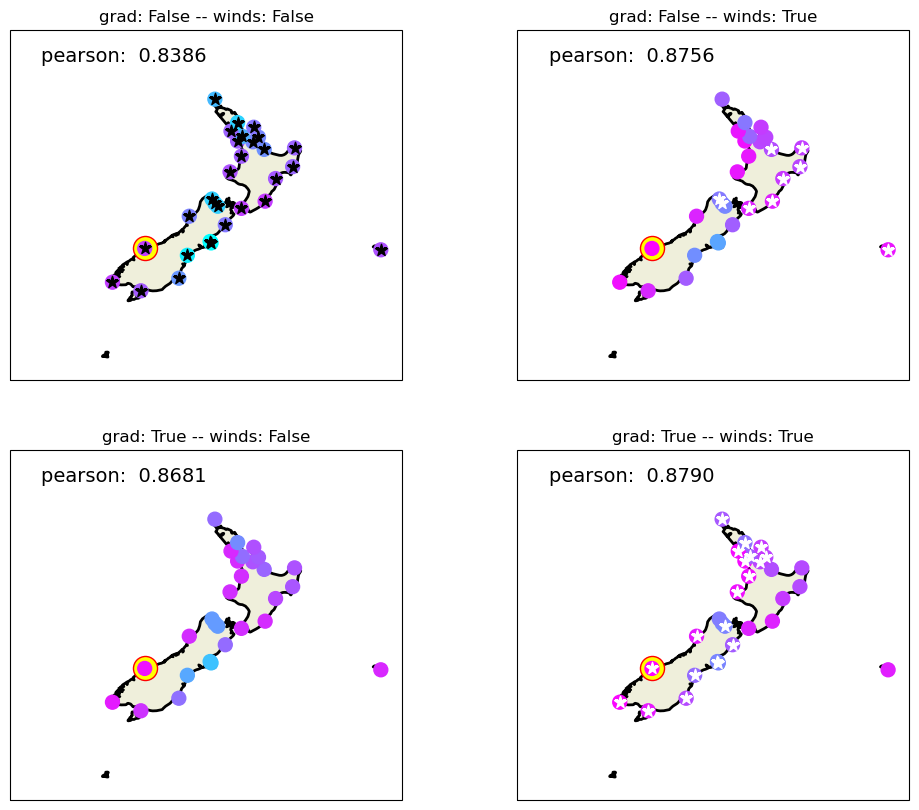

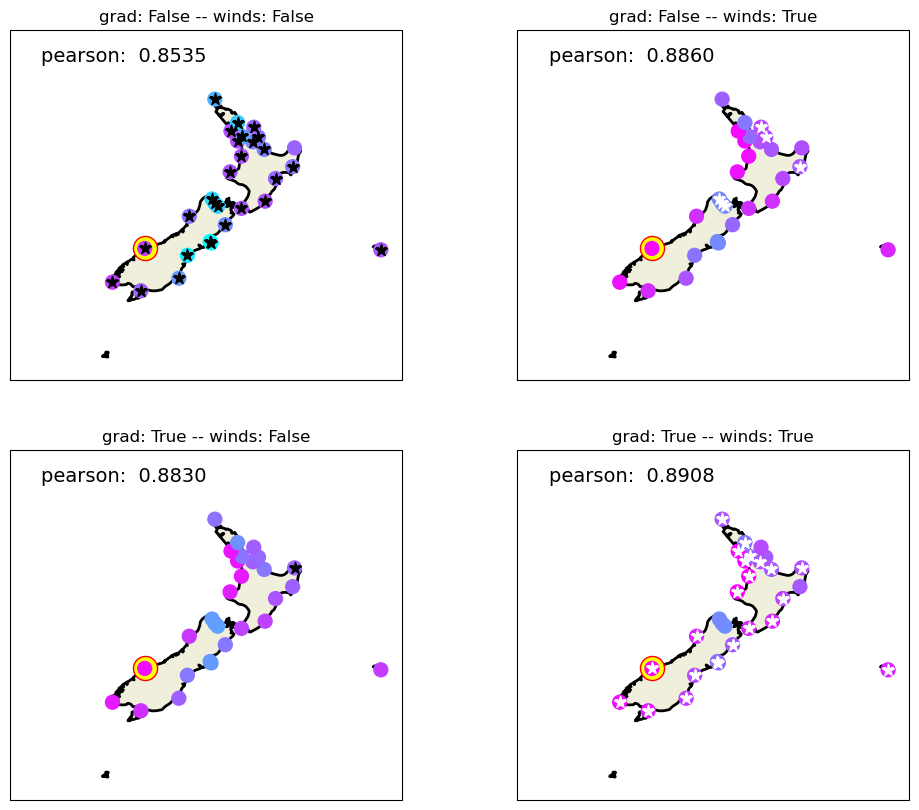

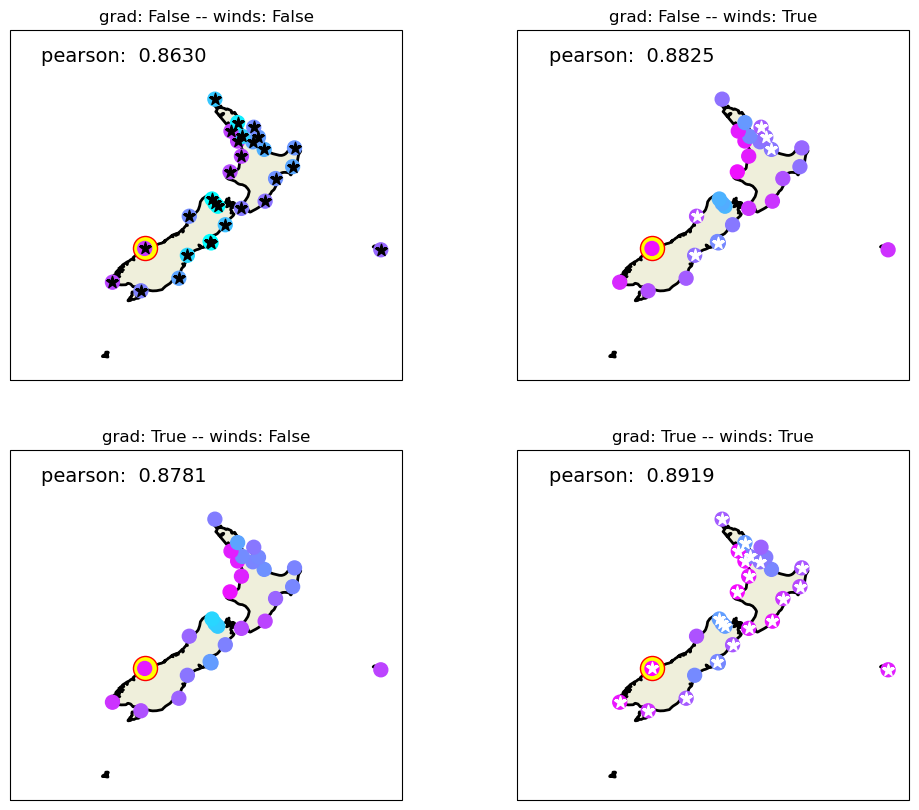

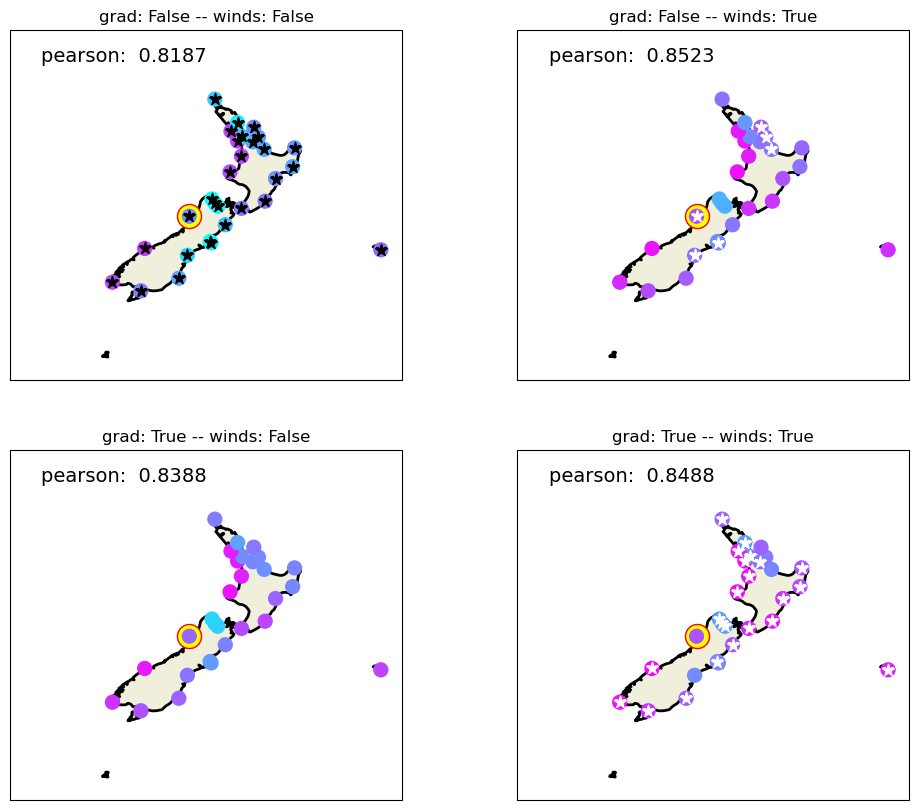

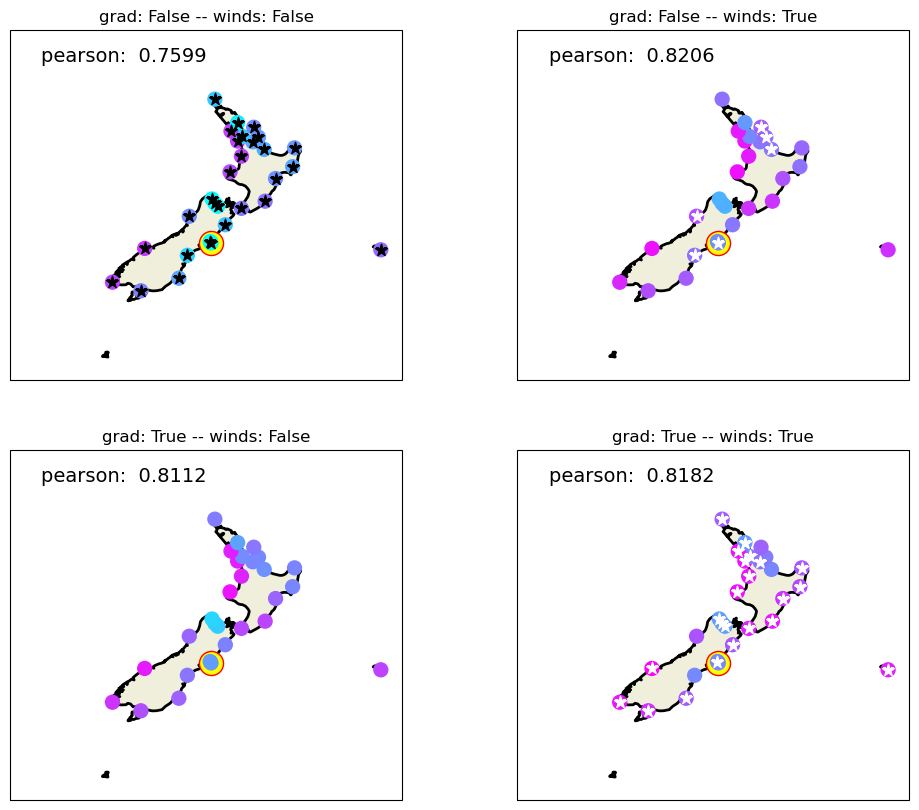

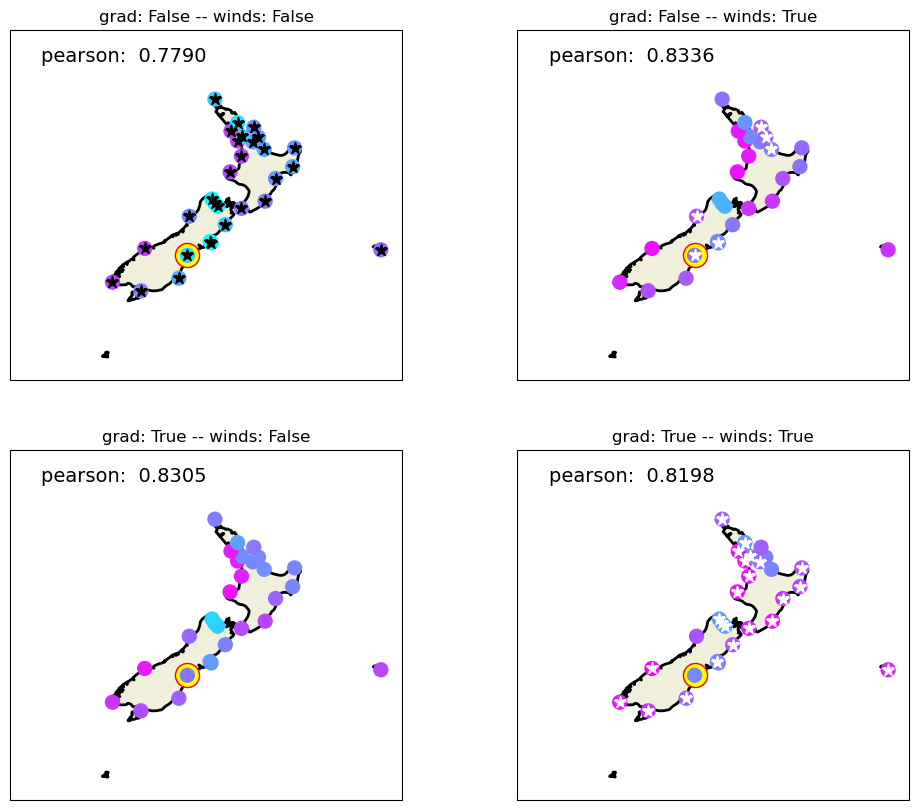

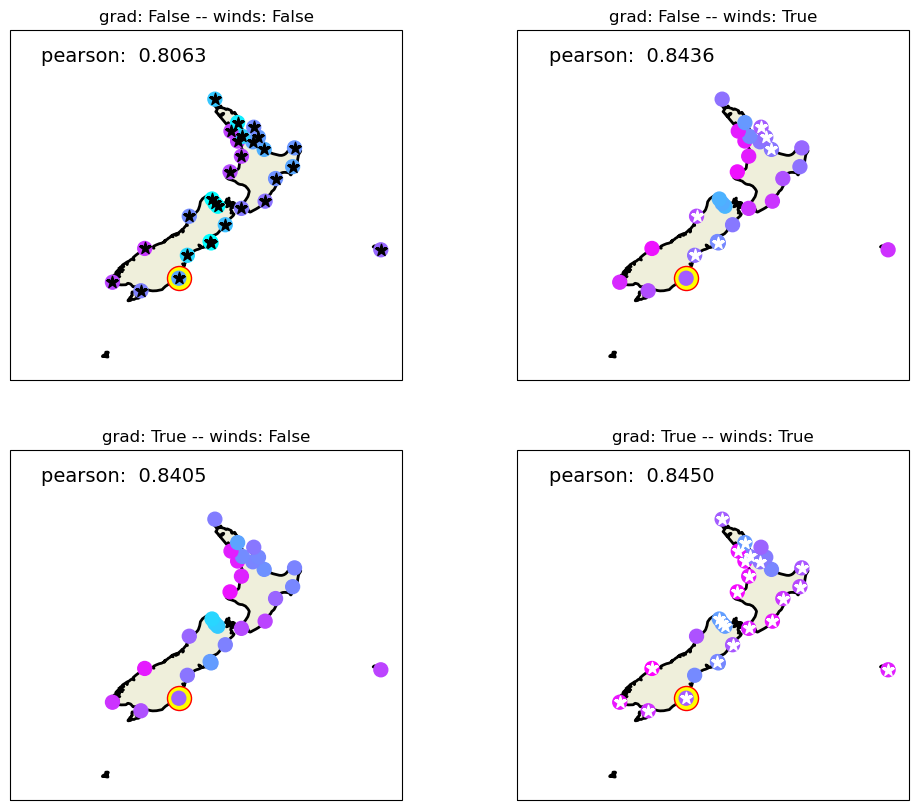

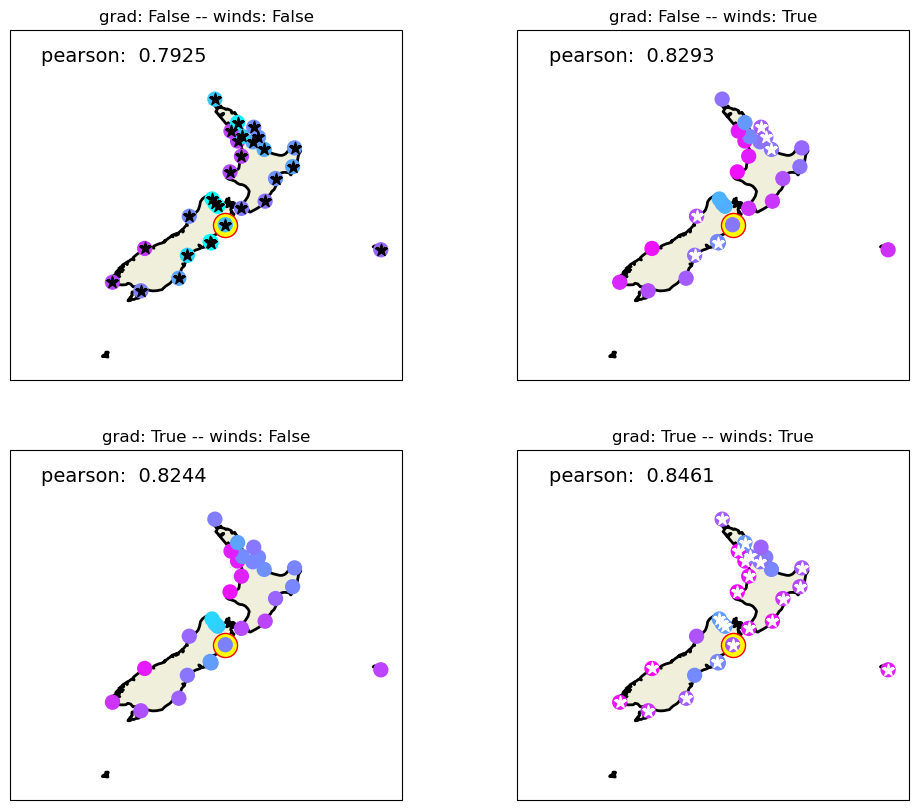

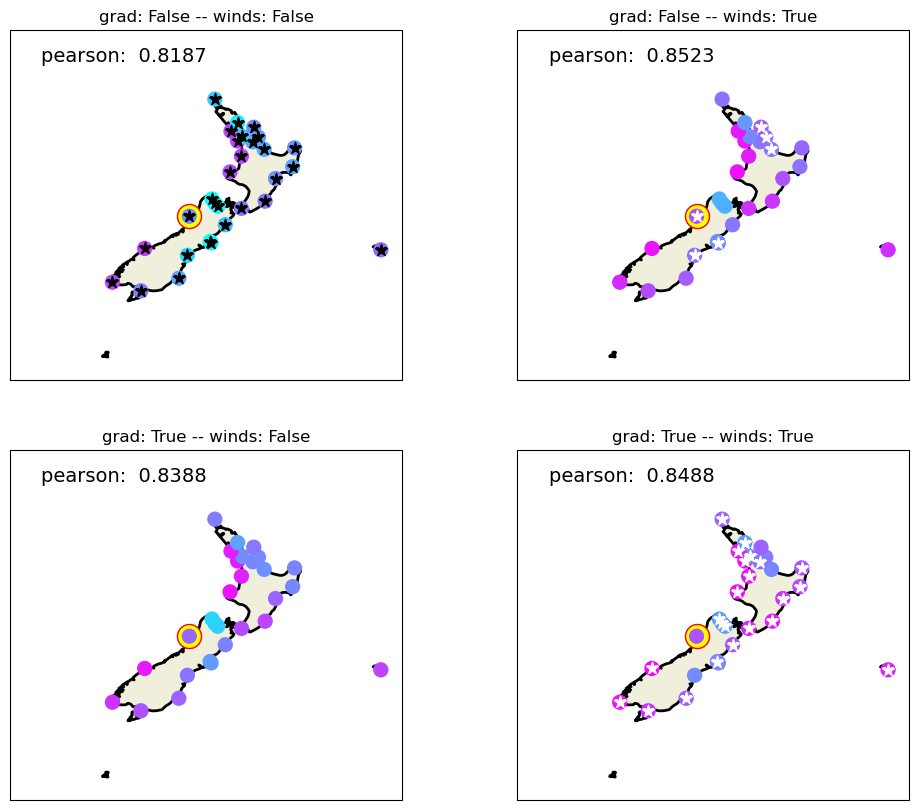

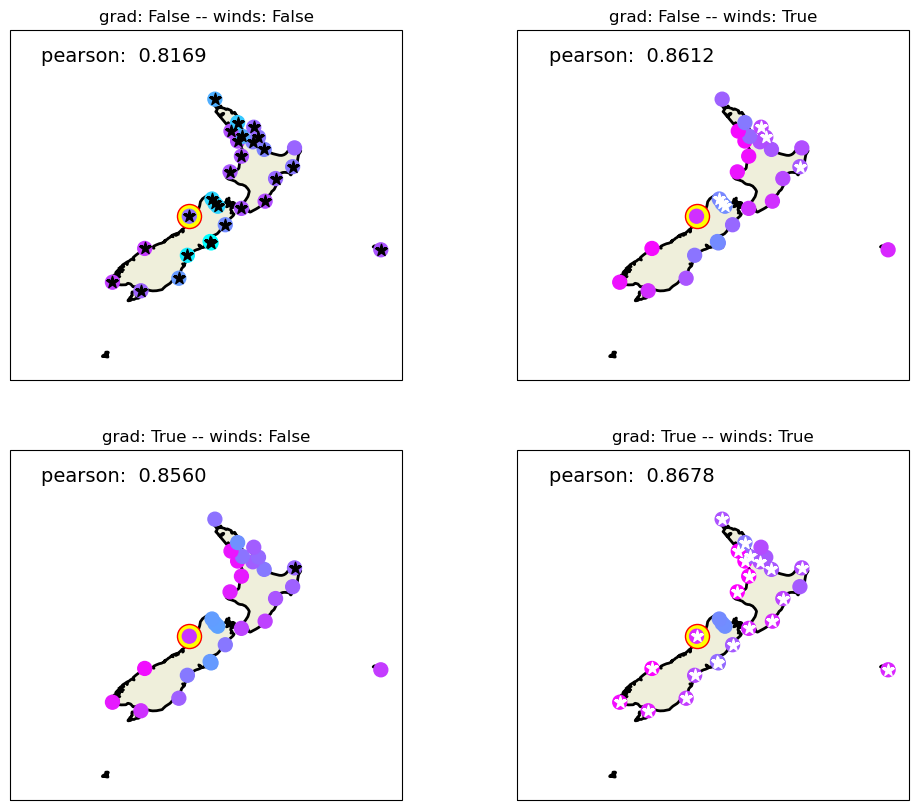

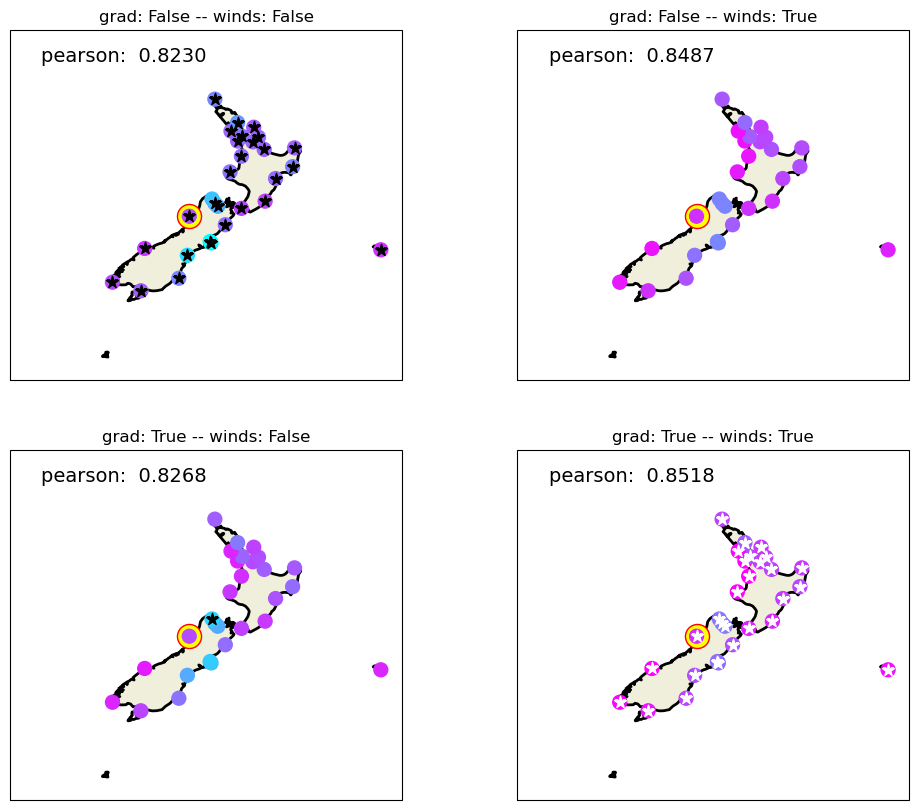

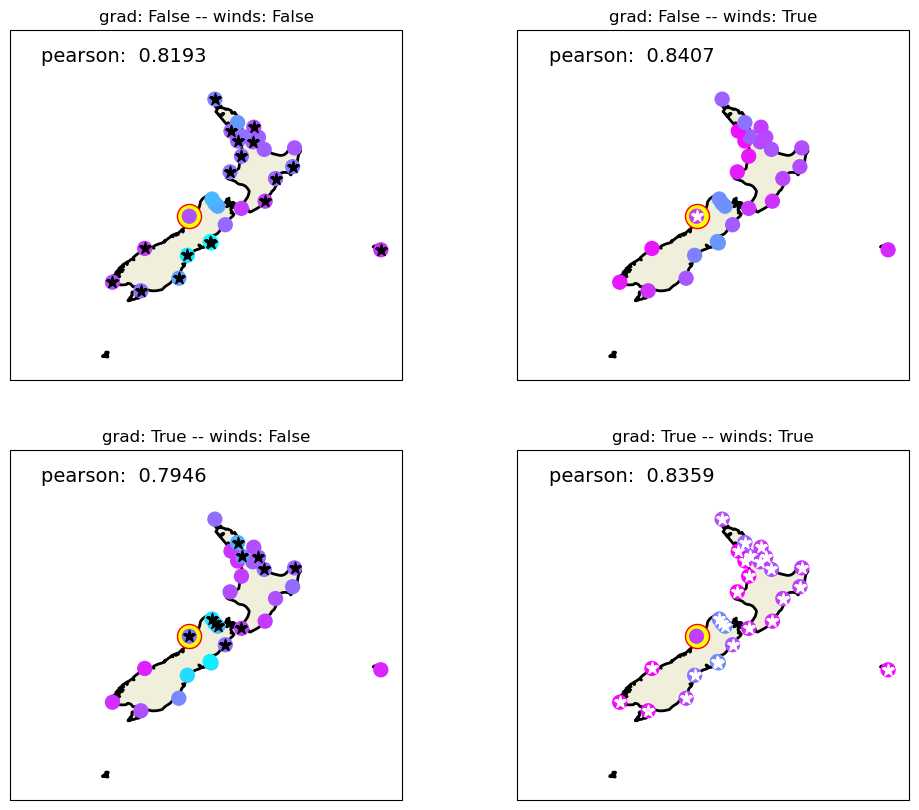

In [14]:
panel.show() # launch interactive server